In [177]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile

from pathlib import Path

import requests
import numpy as np

from torch import nn
from torchvision import transforms
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

torch version: 2.3.1+cpu
torchvision version: 0.18.1+cpu


In [178]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Input and Output Paths

In [179]:
denoised_oct_training_dataset = "D:/VIP Cup/Output dataset/denoised_pkl_dataset"
results = "D:/VIP Cup/Output dataset/classification_results"

Function for open a pickle file

In [180]:
import pickle

def open_pickle(path_to_pkl):

    with open(path_to_pkl, 'rb') as file:
        loaded_vol_oct = pickle.load(file)

    return loaded_vol_oct

In [181]:
import random
from sklearn.model_selection import train_test_split

def split_train_test_data(dataset, test_ratio: float):
    """
    Split the dataset into training and testing datasets.

    Parameters:
    - dataset: The dataset to be split.
    - test_ratio: The ratio of the testing dataset size to the total dataset size.

    Returns:
    - train_dataset: The training dataset as paths.
    - test_dataset: The testing dataset as paths.
    """

    random.seed(42)
    train_dataset, test_dataset = [],[]

    labels = os.listdir(dataset)
    for label in labels:
        label_path = os.path.join(dataset, label)
        vol_images = os.listdir(label_path)
        train_images, test_images = train_test_split(vol_images, test_size=test_ratio, random_state=42)
        train_image_count = len(train_images)
        test_image_count = len(test_images)

        for train_image in train_images:
            train_dataset.append(os.path.join(label_path, train_image))
        for test_image in test_images:
            test_dataset.append(os.path.join(label_path, test_image))

        print(f"class {label} has {train_image_count} training images and {test_image_count} testing images.")
        

    return train_dataset, test_dataset, labels

In [182]:
train_dataset_path, test_dataset_path, classes = split_train_test_data(denoised_oct_training_dataset, test_ratio=0.1667)
print()
print(f"Number of training samples: {len(train_dataset_path)}")
print(f"Number of testing samples: {len(test_dataset_path)}")

class 0 has 34 training images and 8 testing images.
class 1 has 24 training images and 6 testing images.
class 2 has 23 training images and 5 testing images.

Number of training samples: 81
Number of testing samples: 19


In [183]:
train_dataset_path

['D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (37).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (15).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (34).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (20).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (25).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (18).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (23).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (4).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (24).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (42).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (41).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (1).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (31).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl

In [184]:
test_dataset_path

['D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (32).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (21).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (17).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (33).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (13).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (7).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (27).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (36).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (7).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (23).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (30).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (25).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (17).pkl',
 'D:/VIP Cup/Output dataset/de

Creating the volumetric dataset

In [185]:
def create_vol_datasets(dataset):
    """load pickle files as a numpy array associated with their labels and return them as a dataset"""
    
    dataset_list = []
    for path in dataset:
        vol_oct = open_pickle(path)
        label = os.path.basename(os.path.dirname(path))
        dataset_list.append((vol_oct, label))
    return dataset_list

In [186]:
train_vol_dataset = create_vol_datasets(train_dataset_path)
test_vol_dataset = create_vol_datasets(test_dataset_path)

In [187]:
len(train_vol_dataset), len(test_vol_dataset)

(81, 19)

Creating 2D sclices of dataset from 

In [188]:
def create_2D_dataset(vol_dataset):
    """create a 2D dataset from the 3D dataset"""
    
    dataset_2D = []
    for vol_oct, label in vol_dataset:
        m = vol_oct.shape[2]
        for i in range(m):
            dataset_2D.append((vol_oct[:,:,i], label))
    return dataset_2D

In [189]:
train_dataset = create_2D_dataset(train_vol_dataset)
test_dataset = create_2D_dataset(test_vol_dataset)


In [190]:
import numpy as np

# Create or load your 2D NumPy array
array_2d = train_dataset[0][0]  # A 2D array of size 300x300

# Convert the 2D array to a 3D array with shape (300, 300, 1)
array_3d = np.expand_dims(array_2d, axis=-1)

# Check the shape of the resulting array
print("Shape of 2D array:", array_2d.shape)
print("Shape of 3D array:", array_3d.shape)

Shape of 2D array: (300, 300)
Shape of 3D array: (300, 300, 1)


In [192]:
training_cases = len(train_dataset)
testing_cases = len(test_dataset)
total_cases = training_cases + testing_cases
test_ratio = testing_cases / total_cases

print(f"Number of training samples: {training_cases}")
print(f"Number of testing samples: {testing_cases}")
print(f"Number of total samples: {total_cases}")
print(f"Ratio of the testing dataset size to the total dataset size: {test_ratio:.4f}")
print(f"Sample shape of the training data: {train_dataset[0][0].shape}")

Number of training samples: 14698
Number of testing samples: 3340
Number of total samples: 18038
Ratio of the testing dataset size to the total dataset size: 0.1852
Sample shape of the training data: (300, 300)


Class Names

In [193]:
classes

['0', '1', '2']

In [194]:
class_names = {classes[0]: "Normal", classes[1]: "Diabetes", classes[2]: "non-Diabetes"}
class_names

{'0': 'Normal', '1': 'Diabetes', '2': 'non-Diabetes'}

We are intending to use ResNet-101 for the classification task. We will use the pre-trained model.

Creating the transforms

In [195]:
#Get a set of pretrained model weights

# Get the weights
weights = torchvision.models.ResNet101_Weights.DEFAULT
weights

ResNet101_Weights.IMAGENET1K_V2

In [196]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Create manual transforms to include the RGB conversion also

In [242]:
from PIL import Image
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

class GrayscaleToRGB:
    def __call__(self, image):
        if image.ndim == 2:  # Grayscale image
            # Scale float values to [0, 255] and convert to uint8
            img = (image * 255).astype(np.uint8)
            # Stack to create a 3-channel RGB image
            img = np.stack((img,) * 3, axis=-1)
            img2 = Image.fromarray(img)
        else:  # RGB image
            # Scale float values to [0, 255] and convert to uint8
            img = (image * 255).astype(np.uint8)
            img2 = Image.fromarray(img)
        return img2

crop_size = 300
resize_size = 232
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BILINEAR

final_transform = transforms.Compose([
    GrayscaleToRGB(),
    #transforms.CenterCrop(crop_size),
    #transforms.Resize(resize_size, interpolation=interpolation),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

testing

In [243]:
#`sample` is a numpy array representing a grayscale image
sample = train_dataset[0][0]

# Apply the final transformation
a = final_transform(sample)
a

tensor([[[-0.5596, -0.5082, -0.3541,  ..., -0.5253, -0.4397, -0.3883],
         [-0.5596, -0.5082, -0.3541,  ..., -0.5424, -0.4226, -0.3883],
         [-0.5596, -0.5082, -0.3541,  ..., -0.5596, -0.4226, -0.3883],
         ...,
         [ 0.0912, -0.0801, -0.0116,  ...,  0.1083,  0.1083,  0.1254],
         [ 0.1083, -0.0629,  0.0056,  ...,  0.1254,  0.1254,  0.1254],
         [ 0.1083, -0.0629,  0.0227,  ...,  0.1254,  0.1426,  0.1254]],

        [[-0.4426, -0.3901, -0.2325,  ..., -0.4076, -0.3200, -0.2675],
         [-0.4426, -0.3901, -0.2325,  ..., -0.4251, -0.3025, -0.2675],
         [-0.4426, -0.3901, -0.2325,  ..., -0.4426, -0.3025, -0.2675],
         ...,
         [ 0.2227,  0.0476,  0.1176,  ...,  0.2402,  0.2402,  0.2577],
         [ 0.2402,  0.0651,  0.1352,  ...,  0.2577,  0.2577,  0.2577],
         [ 0.2402,  0.0651,  0.1527,  ...,  0.2577,  0.2752,  0.2577]],

        [[-0.2184, -0.1661, -0.0092,  ..., -0.1835, -0.0964, -0.0441],
         [-0.2184, -0.1661, -0.0092,  ..., -0

In [244]:
a.shape

torch.Size([3, 300, 300])

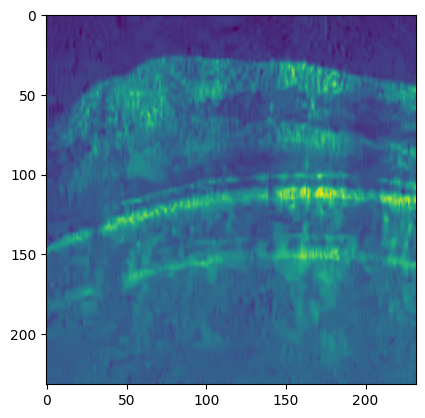

In [238]:
plt.imshow(a[2,:,:])

Creating the dataset with transformed data

In [268]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """creates a custom dataset"""
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

In [269]:
train_dataset[0]

(array([[0.3602106 , 0.36963236, 0.40482548, ..., 0.36588416, 0.38754609,
         0.39784697],
        [0.36010915, 0.36944386, 0.40498698, ..., 0.36151809, 0.38983473,
         0.39774218],
        [0.36048073, 0.37109655, 0.40413761, ..., 0.360349  , 0.39183092,
         0.39884546],
        ...,
        [0.50629044, 0.4697457 , 0.48424375, ..., 0.51213938, 0.51351953,
         0.51544142],
        [0.51053566, 0.47276598, 0.48769131, ..., 0.51471663, 0.51600945,
         0.51488155],
        [0.51183861, 0.47449845, 0.49121377, ..., 0.51666921, 0.51870942,
         0.51389706]]),
 '0')

In [270]:
train_dataset[0][0].shape, train_dataset[0][1]

((300, 300), '0')

Creating datasetss and applying transforms

In [272]:
def create_preprocessed_datasets(dataset, dataset_name:str):
    """create datasets using the CustomDataset class"""

    data, targets = [], []

    for i in range(len(dataset)):
        data_array = dataset[i][0]
        transformed_data = final_transform(data_array)
        data.append(transformed_data)

        targets.append(dataset[i][1])

    print(f"Number of {dataset_name} samples: {len(data)}")
    print(f"Number of {dataset_name} targets: {len(targets)}")
    print(f"Number of {dataset_name} datapoints in input list: {len(dataset)}")
    print(f"Sample of {dataset_name} data: {data[0]} and data shape: {data[0].shape}")
    print(f"Sample of {dataset_name} target: {target[0]}")

    return data, targets

Creating train and test datasets

In [273]:
train_data, train_targets = create_preprocessed_datasets(train_dataset, "training dataset")
test_data, test_targets = create_preprocessed_datasets(test_dataset, "testing dataset")

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1080000 bytes.

In [ ]:
train_data = CustomDataset(train_data, train_targets)
test_data = CustomDataset(test_data, test_targets)

Creating DataLoaders

In [248]:
import os
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloader(
    dataset: , 
    batch_size, 
    shuffle=True, 
    drop_last=True, 
    num_workers=NUM_WORKERS, 
    pin_memory=True
):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
)